### XGBOOST 

First, make sure to import needed libraries.

In [1]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# internal packages src/
from utils.load_and_preprocess import load_and_preprocess, missing_data, create_features, split_train_test
from models.xgboost_model import train_model_xgboost, predict_xgboost
from utils.plot import plot_method1, plot_method2, plot_method3


### load_and_preprocess

1. Load CSV Files
2. Standardize Column Names
3. Merge sales and stock tables on date and product_id
4. Campaign_dates_df includes a row for each day a campaign is active. merge it to dataset. Clean ActiveCampaign "NA" values with binary 0

In [2]:
merged_df = load_and_preprocess('../data/sell_data_cleaned.csv', '../data/marketing_campaign.csv', '../data/stock.csv')
missing_data(merged_df)

,Total,Percent,Types
ID,0,0.0,int64
Product,0,0.0,object
Date,0,0.0,datetime64[ns]
Quantity,0,0.0,float64
Country,0,0.0,object
CountryStatus,0,0.0,object
ProductStatus,0,0.0,object
Stock,0,0.0,float64
ActiveCampaign,0,0.0,float64


### Before training, your data must be:

1. Numerical (no strings in features, also uint type is not desirable)
2. No NaNs
3. Sorted by Date (especially for lag features)

### Included features:

1. Lag feature( 'StockLag1', 'StockLag7' with lag of 1 and 7 days respectively.)

    - Capture the stock level of a product from previous days.
    - Useful to predict current demand based on past availability

2. Moving Averages (StockMA7, StockMA14)

    - Creates a binary trend feature for modeling, can be used like:

        >If StockMA7 > StockMA14: Short-term stock increase.
        
        >If StockMA7 < StockMA14: Potential downward trend.

#### Also worth to mention.

XGBoost model(since it's tree-based) require numerical inputs. Cuz of that need to encode 'CountryStatus', 'ProductStatus' and other with numerical values.

In [3]:
featured_df = create_features(merged_df)
missing_data(featured_df)

,Total,Percent,Types
ID,0,0.0,int64
Product,0,0.0,object
Date,0,0.0,datetime64[ns]
Quantity,0,0.0,float64
Country,0,0.0,object
CountryStatus,0,0.0,int64
ProductStatus,0,0.0,int64
Stock,0,0.0,float64
ActiveCampaign,0,0.0,float64
Year,0,0.0,int32


In [4]:
train_df, test_df, cutoff_date = split_train_test(featured_df)
train_df.head()

features = [
    'Year', 'Month', 'Week', 'DayOfWeek', 'DayOfMonth',
    'CountryEncoded', 'ProductEncoded', 'CountryStatus', 'ProductStatus',
    'ActiveCampaign', 'Stock', 'StockLag1', 'StockLag7', 'StockMA7', 'StockMA14'
]

print(train_df.columns.tolist())
model = train_model_xgboost(train_df, features)

['ID', 'Product', 'Date', 'Quantity', 'Country', 'CountryStatus', 'ProductStatus', 'Stock', 'ActiveCampaign', 'Year', 'Month', 'Week', 'DayOfWeek', 'DayOfMonth', 'StockLag1', 'StockLag7', 'StockMA7', 'StockMA14', 'StatusCombination', 'CountryEncoded', 'ProductEncoded']


In [5]:
test_df = predict_xgboost(model, test_df, features)

rmse = np.sqrt(mean_squared_error(test_df['Quantity'], test_df['Predicted']))
mae = mean_absolute_error(test_df['Quantity'], test_df['Predicted'])
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}')

RMSE: 26.12, MAE: 7.00


### plot_method1

Purpose: Visualizes model performance over time for each country by comparing actual vs. predicted sales quantities.

- Loops through each country in the training data.

    For each country skips countries that have no test data.

    1. Aggregates total actual sales (Quantity) and predicted sales (Predicted) for each date.

    2. Splits the aggregated data into:

        - Training period (up to the cutoff date)
        - Testing period (after the cutoff date)

    3. Plots the actual vs. predicted sales:

        - Actual training data: white line
        - Actual test data: yellow line
        - Predicted test data: red line

    4. Styles the plot with a dark background and labeled axes.

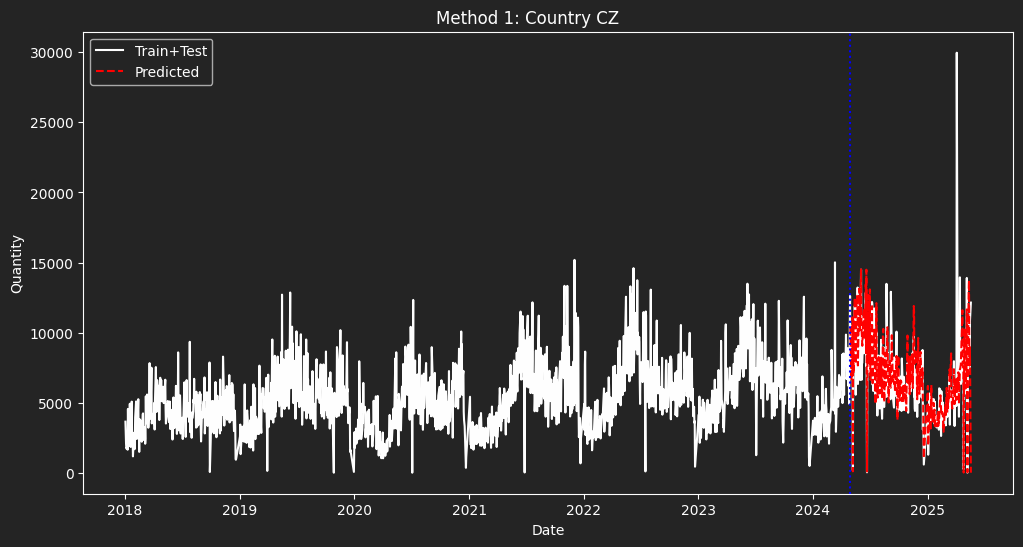

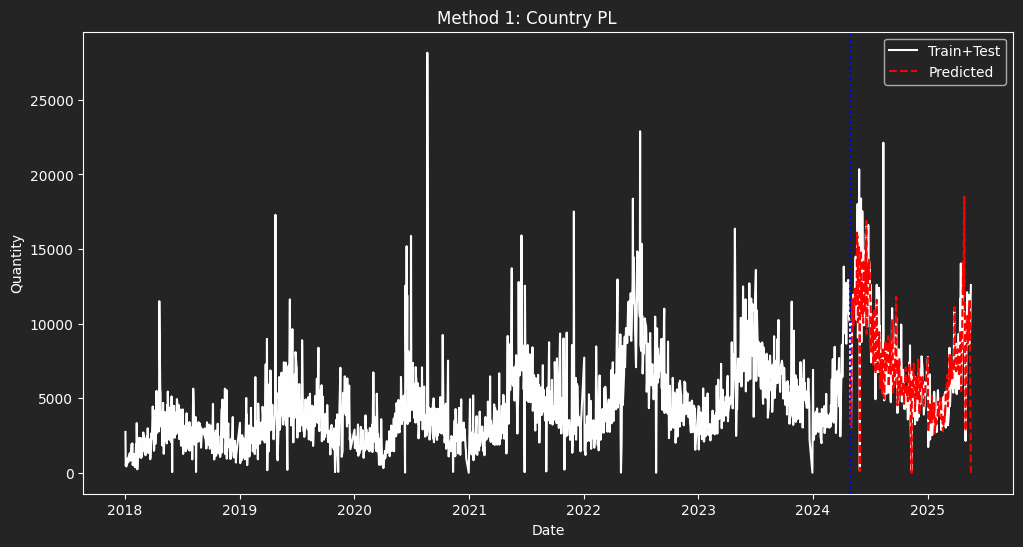

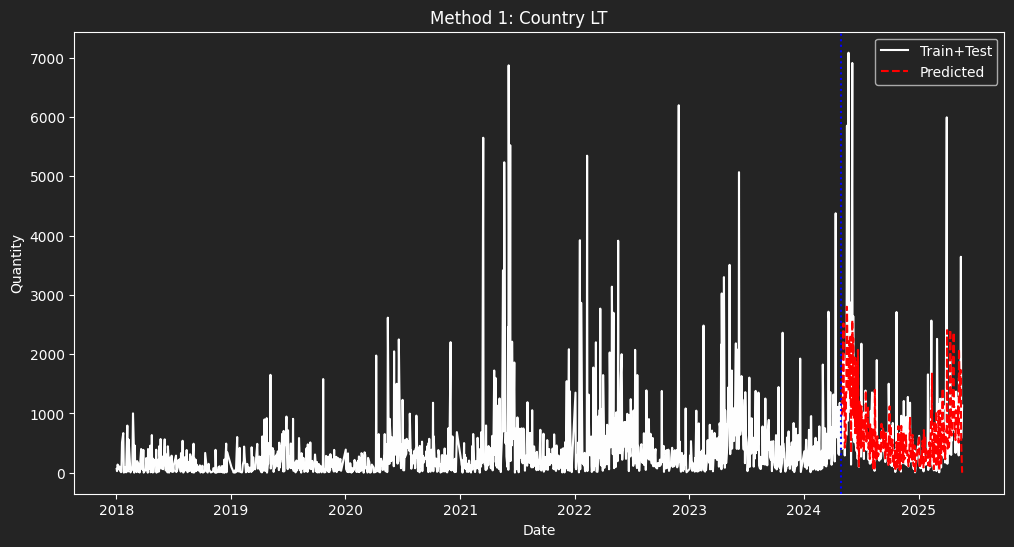

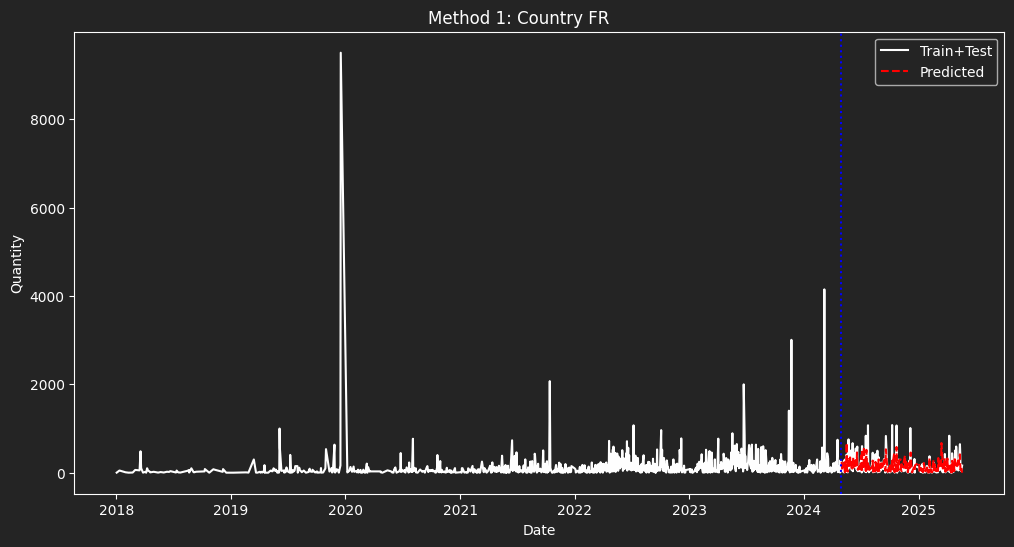

In [6]:
plot_method1(train_df, test_df, cutoff_date)

### plot_method2

Shows the model's performance over time across all products and countries.

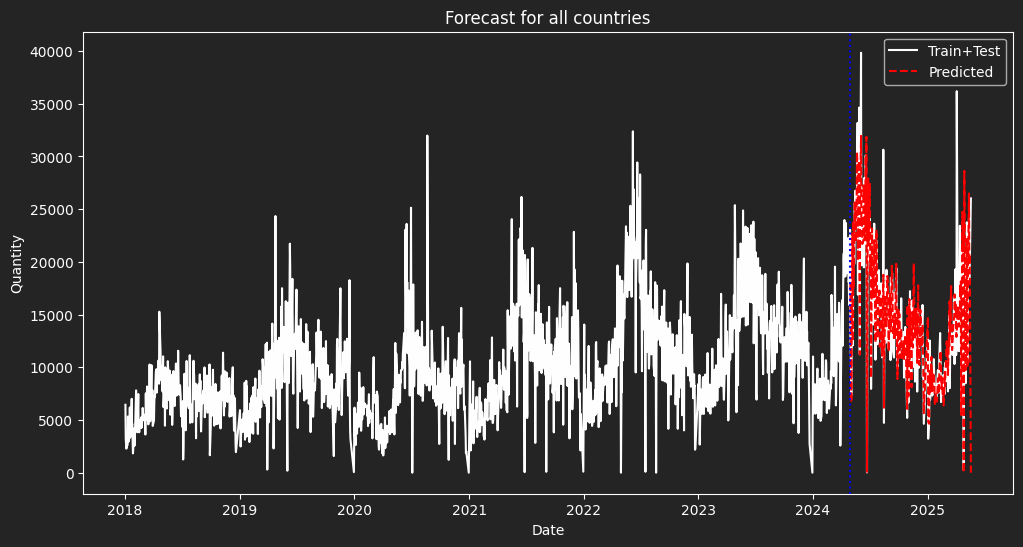

In [7]:
plot_method2(train_df, test_df, cutoff_date)

#### plot_method3

Useful to analyze model performance across status-driven segments (e.g., active vs inactive products in certain regions). It helps answer:

    -Does the model perform better when both country and product are active?

    -Do inactive combinations behave differently over time?

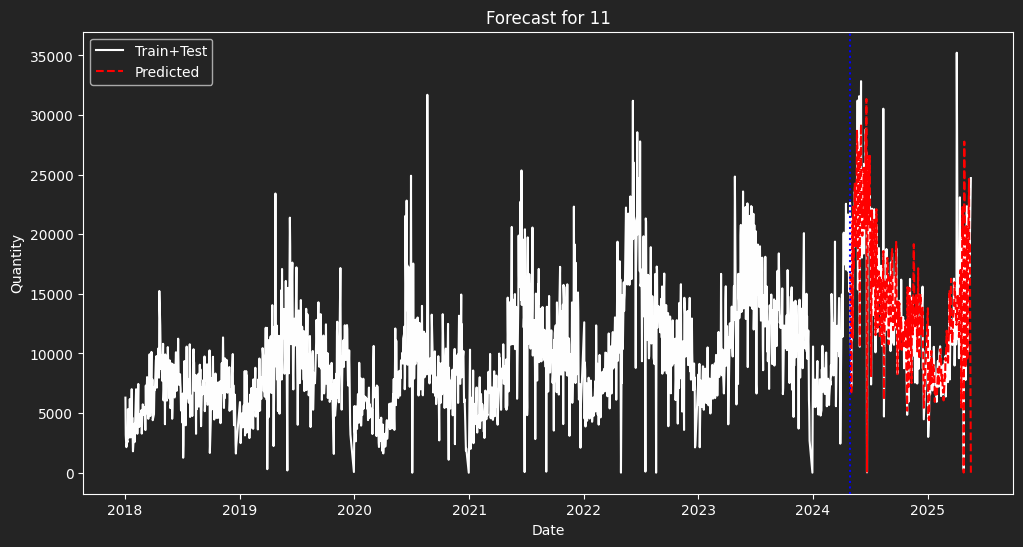

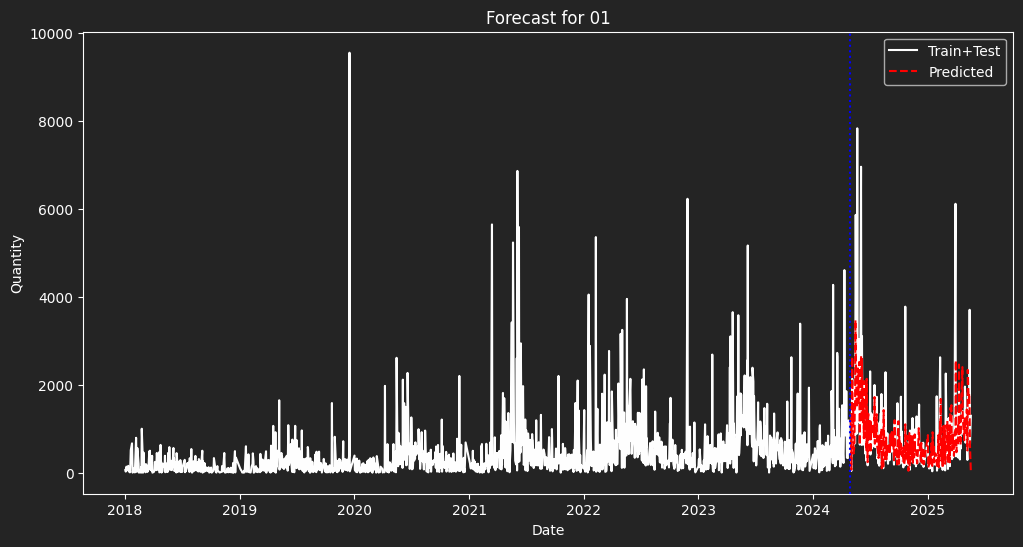

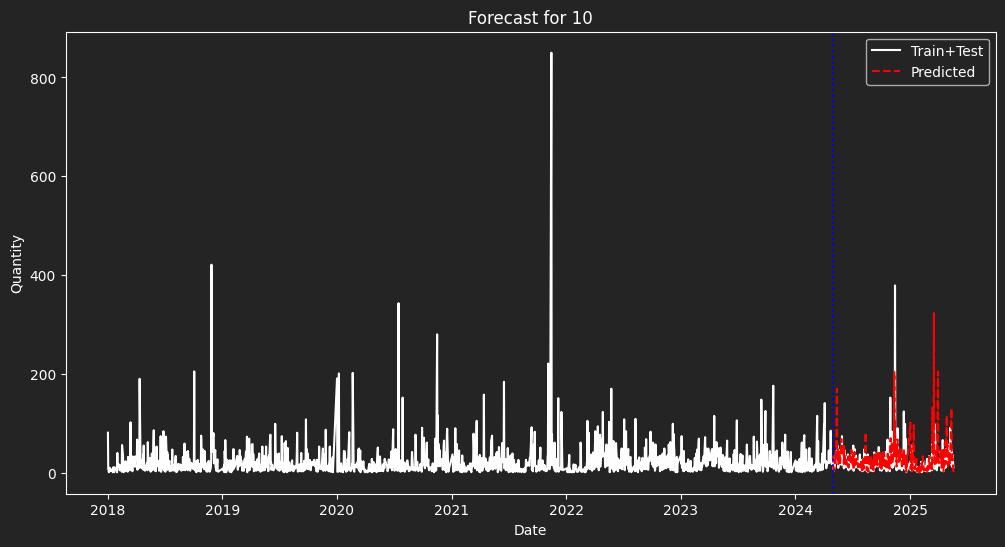

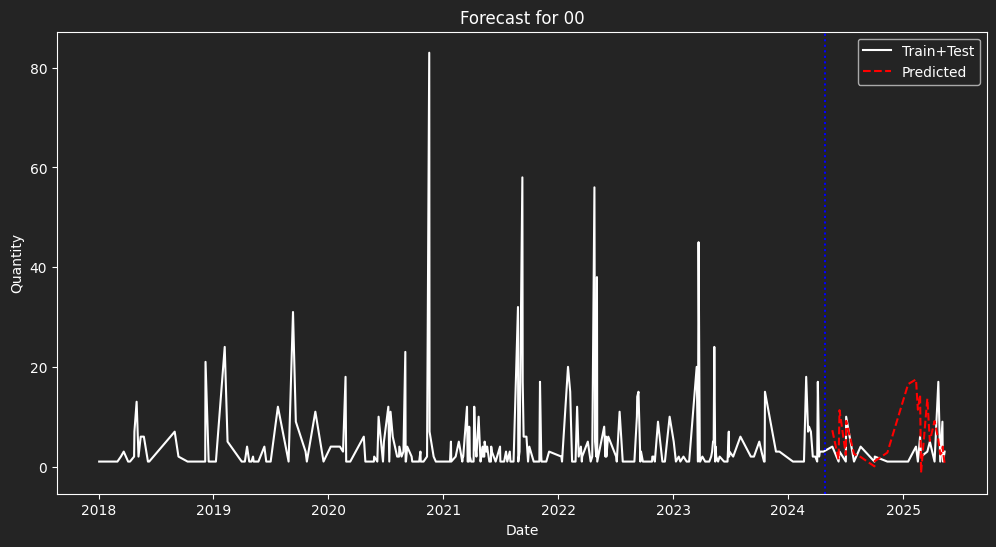

In [8]:
plot_method3(train_df, test_df, cutoff_date)